In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/flickr30k /content/
!tar zxvf /content/flickr30k
!cp /content/drive/MyDrive/dataset.json /content

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
import numpy as np
import torch
import os
from pkg_resources import packaging
import torchvision

print("Torch version:", torch.__version__)
fdata=torchvision.datasets.Flickr30k("/content/flickr30k-images","/content/drive/MyDrive/results_20130124.token")

In [ ]:
import clip
import numpy as np
import torch
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
# model, preprocess = clip.load("ViT-B/32")
model, preprocess = clip.load("ViT-L/14@336px")

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print(preprocess)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408
Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7f5b0d0464c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


<class 'tuple'>
<class 'list'>
<class 'str'>

['The man with pierced ears is wearing glasses and an orange hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .']



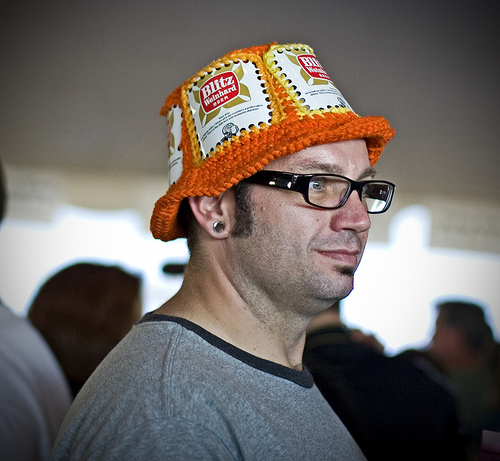

In [ ]:
import PIL
print(type(fdata.__getitem__(25)))
print(type(fdata.__getitem__(25)[1]))
print(type(fdata.__getitem__(25)[1][0]))
print()
print(fdata.__getitem__(25)[1])

print()
fdata.__getitem__(25)[0]

In [ ]:
# !wget "https://diskasu.pku.edu.cn:10002/Bucket/bab1d452-c23b-4d03-b766-329261bcc4d6/C72E241EFD9C414F8B147EF583B4784F/9F02CA939E784E548F10659D94FB9CA5?response-content-disposition=attachment%3b%20filename%3d%22dataset.json%22%3b%20filename*%3dutf%2d8%27%27dataset.json&AWSAccessKeyId=ASE&Expires=1671115756&Signature=kwvGheJvwxRR4juQNMQv8mOIpVw%3d" -O "/content/dataset.json"

In [ ]:
import json
import time
with open (r"/content/dataset.json","r") as f:
  row_data= json.load(f)
# print(type(row_data))
k=0
all_data=[]
for l in row_data:
  print(l)
  for i in row_data[l]:
    if k==1000:
      break
      print("breakk")
    if i["split"]=="test":
      k+=1
      all_data.append(i)

images
dataset


In [ ]:
all_txt=[]
all_raw_txt=[]
all_img_name=[]
all_test_img_id=[]
all_test_img_name=[]
ooo=0
ook=0
for i in all_data:
  all_test_img_id.append(i["imgid"])
  all_test_img_name.append(i["filename"])
  # print(i["imgid"])
  # print(fdata.__getitem__(i["imgid"])[1])
  ooo+=1
  if ooo%100==0:
      print(ooo)
  else:
    ook=1
  for j in i["sentences"]:
    txt="This is "+j["raw"]
    # txt=j["raw"]
    all_raw_txt.append(txt)
    txt2=clip.tokenize(txt,truncate = True).to("cuda:0")
    
    with torch.no_grad():
      txt3=model.encode_text(txt2).float().view(768)

    all_txt.append(txt3.to("cpu"))
    all_img_name.append(i["filename"])

    # print("~~~~~~~~~~~~~~~~~~~~")
    # time.sleep(1)
  # break

100
200
300
400
500
600
700
800
900
1000


In [ ]:
model2, preprocess2 = clip.load('ViT-B/16')

In [ ]:
a="a boy play send"
b="This is a boy play send"
cx=[a,b]

In [ ]:
at=clip.tokenize(a,truncate = True).to("cuda:0")
bt=clip.tokenize(b,truncate = True).to("cuda:0")
ggg=clip.tokenize(cx,truncate = True).to("cuda:0")
# print(at,bt)
c=[at,bt]
ct=torch.stack((at,bt))
with torch.no_grad():
  ae=model2.encode_text(at).float()
  ae/=ae.norm(dim=-1, keepdim=True)
  be=model2.encode_text(bt).float()
  be/=be.norm(dim=-1, keepdim=True)
  ge=model2.encode_text(ggg).float()
  ge/=ge.norm(dim=-1, keepdim=True)

In [ ]:
sm=ae @ be.T
print(sm)

tensor([[0.9721]], device='cuda:0')


In [ ]:
print(be)

In [ ]:
print(len(all_data))
print(len(all_txt))
print(len(all_test_img_id))
# all_txt=[]
# all_img_id=[]

1000
5000
1000


In [ ]:
def RN(tp,fn):
# 真正例(True Positive, TP)：被模型预测为正的正样本
# 假负例(False Negative, FN)：被模型预测为负的正样本
# R@N: topN 结果的召回率
  return tp/(tp+fn)

In [ ]:
st=np.stack(all_txt)
text_features=torch.tensor(st)
print(text_features.size())

torch.Size([5000, 768])


In [ ]:
text_features=torch.tensor(st)
text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_features.size())

torch.Size([5000, 768])


In [ ]:
img_features=[]
for i in all_test_img_name:
  img=PIL.Image.open("/content/flickr30k-images/"+i)
  img2=preprocess(img).to("cuda:0")
  # img2=img2.view(1,3,224,224)
  img2=img2.view(1,3, 336, 336)

  with torch.no_grad():
    img_f=model.encode_image(img2).float()

  img_features.append(img_f.view(768).to("cpu"))

In [ ]:
st=np.stack(img_features)
image_features2=torch.tensor(st)
print(image_features2.size())

torch.Size([1000, 768])


In [ ]:
image_features2=torch.tensor(st)
image_features2 /= image_features2.norm(dim=-1, keepdim=True)

In [ ]:
print(image_features2.size())
print(text_features.T.size())

torch.Size([1000, 768])
torch.Size([768, 5000])


In [ ]:
similarity = text_features.cpu().numpy() @image_features2.cpu().numpy().T
similarity=torch.tensor(similarity)
print(similarity)

tensor([[0.2325, 0.1169, 0.1392,  ..., 0.1403, 0.1817, 0.1089],
        [0.3651, 0.0804, 0.1002,  ..., 0.1108, 0.1306, 0.0681],
        [0.2476, 0.1286, 0.1000,  ..., 0.0946, 0.1694, 0.0789],
        ...,
        [0.0652, 0.0984, 0.0944,  ..., 0.0807, 0.0723, 0.2669],
        [0.0619, 0.0988, 0.0602,  ..., 0.1033, 0.0353, 0.2695],
        [0.0602, 0.1097, 0.1388,  ..., 0.1366, 0.1100, 0.2475]])


In [ ]:
print(similarity.topk(10)[1].size())
print(similarity.size())

torch.Size([5000, 10])
torch.Size([5000, 1000])


# 计算R@1

In [ ]:
right1=0
wrong1=0
for i in range(5000):
  line=topNs[i]
  if line[0]==i//5:
    # print("ok",line[0])
    right1+=1
  else:
    # print("wrong",line[0])
    wrong1+=1
print(right1,wrong1)
print(right1/5000)

3403 1597
0.6806


# 计算R@5

In [ ]:
right5=0
wrong5=0
for i in range(5000):
  line=topNs[i]
  for j in range(5):
    if line[j]==i//5:
      # print("ok",line[j])
      right5+=1
    else:
      # print("wrong",line[j])
      wrong5+=1
print(right5)
print(right5/5000)

4476
0.8952


# 计算R@10

In [ ]:
right10=0
wrong10=0
for i in range(5000):
  line=topNs[i]
  for j in range(10):
    if line[j]==i//5:
      # print("ok",line[j])
      right10+=1
    else:
      # print("wrong",line[j])
      wrong10+=1
print(right10)
print(right10/5000)

4691
0.9382
